# Прогнозирование заказов такси 

В ходе нашего проекта мы реализуем модель, которая посредством предсказаний количества заказов такси на следующий час, позволит привлечь больше водителей в период пиковой нагрузки для компании "Чётенькое такси".
Для этого мы изучим имеющиеся данные по заказу такси в разные часы, проведем предобработку имеющихся данных, подготовим данные для моделирования и, используя различные типы, создадим модели машинного обучения. Среди моделей выберем более подходящую и проведем соответсвующее тестирование выбранной модели. 

In [23]:
#Импортируем все используемые в проекте библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from numpy.random import RandomState
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ( mean_absolute_error, make_scorer, mean_squared_error )
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

# 1. Предобработка данных 

Первоначально изучим имеющиеся данные. 

In [24]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0]) 
data.sort_index(inplace=True)

In [25]:
def preview_of_data(data):
    print('Общая  информация о о данных')
    print(data.info())
    print(data.head())

In [26]:
preview_of_data(data)

Общая  информация о о данных
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None
                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32


Проверим монотонность полученного временного ряда. 

In [27]:
print(data.index.is_monotonic)

True


**Вывод**: имеющиеся данные считаны, упорядочены и проверены на монотонность.

Для дальнейшего удобства проведем ресемплирование данных по 1 часу и отобразим это на графике. 

Text(0, 0.5, 'Количество заказов')

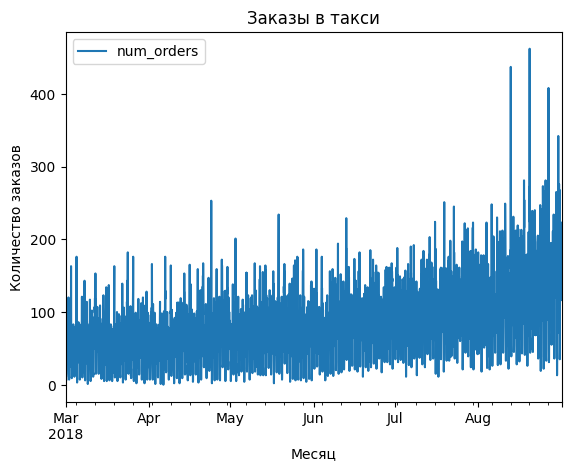

In [28]:
data = data.resample('1H').sum()
data.plot()
plt.title('Заказы в такси')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')

Изучим тренды и сезонность.

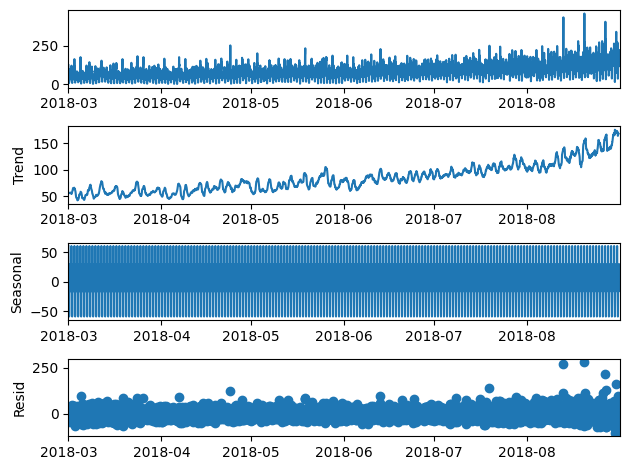

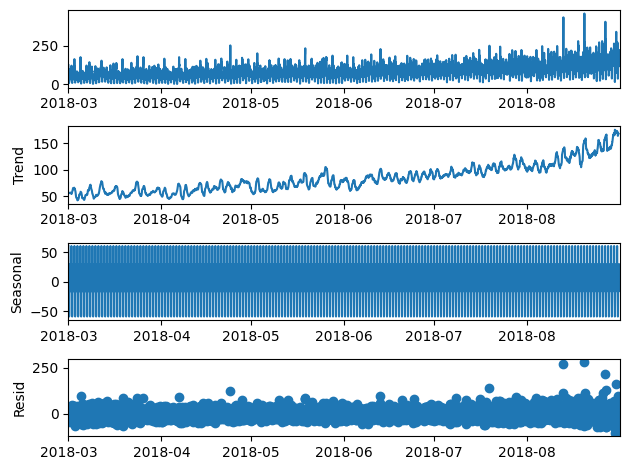

In [29]:
decomposed = seasonal_decompose(data)
decomposed.plot()

**Вывод**: за рассматриваемый промежуток можно увидеть возрастающий тренд к концу лета.

# 2. Подготовка данных к моделированию

In [30]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    # < напишите код здесь >
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [31]:
make_features(data, 24, 10)

In [32]:
data = data.dropna()

In [33]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train.shape[0]/test.shape[0]

8.981818181818182

In [80]:
train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']


# 3.Моделирование

Для моделирования воспользуемся критерием оценки качества RMSE и подберем наилучшие гиперпараметры для двух моделей - градиентного бустинга и случайного леса. 

In [35]:
#Создадим функцию оценки по mean_squared_error
def rmse(prediction, target):
    return (mean_squared_error(target,prediction)**0.5).round(2)
scorer = make_scorer(rmse, greater_is_better=False)

In [36]:
model = RandomForestRegressor()
grid = {
         'n_estimators': [200, 300, 400],
          'max_depth': [6, 9, 12]
         }
gsearch = GridSearchCV(estimator=model, 
                       cv=TimeSeriesSplit(), 
                       param_grid=grid,  
                       scoring=scorer)
gsearch.fit(train_features, train_target)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [6, 9, 12],
                         'n_estimators': [200, 300, 400]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [37]:
gsearch.best_score_

-25.674

In [38]:
gsearch.best_params_

{'max_depth': 12, 'n_estimators': 300}

In [39]:
model = CatBoostRegressor(verbose = 0)
grid = {'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5]}
gsearch_2 = GridSearchCV(estimator=model, 
                       cv=TimeSeriesSplit(), 
                       param_grid=grid,  
                       scoring = scorer)
gsearch_2.fit(train_features, train_target)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x000001BC8809DD60>,
             param_grid={'depth': [4, 6, 10], 'l2_leaf_reg': [1, 3, 5]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [40]:
gsearch_2.best_score_

-24.613999999999997

In [41]:
gsearch_2.best_params_

{'depth': 6, 'l2_leaf_reg': 1}

**Вывод**: были использованы две модели - модель случайного леса и модель градиентного бустинга. По выбранному параметру качества лучший результат у градиентного бустинга, поэтому воспользуемся именно этой моделью. 

# 4. Тестирование

Проведем тестирование выбранной модели.

In [46]:
predictions = gsearch_2.best_estimator_.predict(test_features)

In [47]:
rmse(predictions, test_target)

39.89

Проведем проверку на адекватность и сравним данные с моделью медианного предсказателя

In [44]:
pred_median = np.ones(test_target.shape)*train['num_orders'].median()

In [45]:
rmse(pred_median, test_target)

87.21

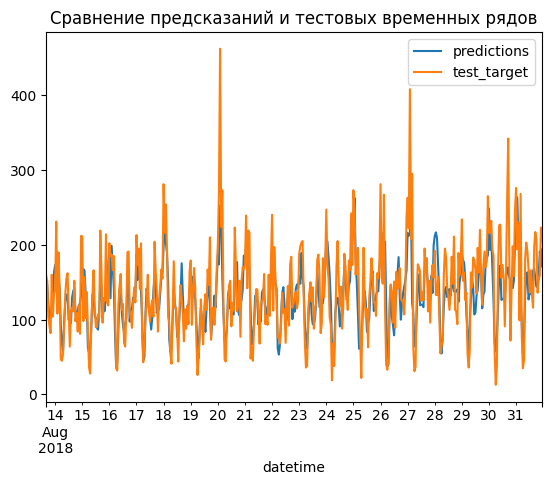

In [92]:
df = pd.DataFrame(data=predictions, index = test_target.index)
df['test_target'] = test_target
df.plot()
plt.title('Сравнение предсказаний и тестовых временных рядов')
plt.legend(['predictions', 'test_target'])

**Вывод**: таким образом, полученный результат параметра **RMSE** = 39.89 и удовлетворяет поставленным требованиям. 

# Вывод

В ходе работы над проектом были проанализированы исходные данные, проведена предварительная обработка. Данные подготовлены для дальнейшего моделирование - были разделены на две выборки тестовую и тренировочную. Из исходных временных рядов были выделены дополнительные признаки, улучшающие возможности моделирования. 

Для моделирования были выбраны две модели - градиентного бустинга и случайного леса. По параметрам качества выбрана модедль градиентного бустинга. 

Было проведено тестирование модели градиентного бустинга на тестовой выборке и полученный параметр качества RMSE составил 39.9, что удовляетворяет поставленным требованиям. 

<div style="border:solid Chocolate 2px; padding: 40px">


<h2> Итоговый комментарий ревьюера <a class="tocSkip"> </h2>    
    
  
У меня сложилось хорошее общее впечатление о проекте, тебе удалось неплохо справиться с этим проектом. Молодец! Подготовлены данные для анализа, изучен каждый параметр. Все красиво визуализировано, построено несколько моделей регрессии и оценено их качество. Осмысленная аналитика и дельная модельная работа - многое удалось как надо)
    
Отмечу отдельные положительные моменты проекта🙂:
    
- в ходе проекта встречались  функции, помогающие избавиться от дублирования кода;
- много красивых визуализаций в проекте и хорошая интерпретация;
- при обучении моделей использована валидация и поиск гиперпараметров.
    
Есть несколько моментов всего, на которые стоит ещё раз взглянуть, я указал их в моих комментариях по ходу проекта. Предлагаю тебе доработать проект по моим комментариям, чтобы довести его до совершенства.

    
 
</div>